In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.patches import Polygon
from shapely.geometry import Point, LineString, MultiPolygon, MultiLineString, shape

In [51]:
class Lane:
    __slots__ = ["queue", "length"]
    def __init__(self, length):
        self.queue = []
        self.length = length
        
    def __repr__(self):
        s = [vehicle.position for vehicle in self.queue]
        return str(s)
    
    def is_empty(self):
        return len(self.queue) == 0
    
    def get_front_vehicle(self, position):
        front_vehicle = None
        for v in self.queue:
            if v.position > position:
                front_vehicle = v
                break
                
        return front_vehicle
    
    def get_front_gap(self, position):
        front_vehicle = self.get_front_vehicle(position)
        if front_vehicle is not None:
            return front_vehicle.position - position - 1
        else:
            return self.length - position - 1
    
    def get_back_vehicle(self, position):
        back_vehicle = None
        for v in reversed(self.queue):
            if v.position < position:
                back_vehicle = v
                break
        
        return back_vehicle
    
    def get_back_gap(self, position):
        back_vehicle = self.get_back_vehicle(position)
        if back_vehicle is not None:
            return position - back_vehicle.position -1
        else:
            return position
        
    def insert(self, vehicle):
        assert vehicle.position < self.length
        if self.is_empty():
            self.queue.append(vehicle)
        else:
            for i in range(self.length):
                assert vehicle.position != self.queue[i].position
                if vehicle.position < self.queue[i].position:
                    self.queue.insert(i, vehicle)
                    break
            else:
                self.queue.append(vehicle)
            

class Road:
    __slots__ = ["lanes", "nexts", "prevs", "world"]
    def __init__(self, length=100, nlanes=3):
        self.nexts = {}
        self.prevs = {}
        self.lanes = []
        for i in range(nlanes):
            self.lanes.append(Lane(length))
    
    @property
    def length(self):
        return self.lanes[0].length
    
    @property
    def nlane(self):
        return len(self.lanes)
    
    def connect(self, next_road, dlane):
        for i, _ in enumerate(self.lanes):
            ilane = i + dlane
            if ilane >= 0 and ilane < next_road.nlane:
                self.nexts[i] = (next_road, ilane)
                next_road.prevs[ilane] = (self, i)
            
    def get_free_lane(self):
        free_lanes = [i for i, lane in enumerate(self.lanes) if lane.get_front_gap(-1)>0]
        if free_lanes:
            return random.choice(free_lanes)
        else:
            return None
    
    def insert_vehicle(self, vehicle, ilane):
        lane = self.lanes[ilane]
        if not lane.is_empty():
            assert vehicle.position < lane.queue[-1].position
            
        lane.insert(vehicle)
        
    def dispatch_request(self):
        pass
    
    def clear_request(self):
        pass
    
    def get_front_gap(self, ilane, position):
        lane = self.lanes[ilane]
        front_vehicle = lane.get_front_vehicle(position)
        if front_vehicle is not None:
            return front_vehicle.position - position - 1
        else:
            gap = lane.length - position - 1
            next = self.nexts.get(ilane, None)
            if next is None:
                gap += 100
            else:
                next_road, next_ilane = next
                gap += next_road.get_front_gap(next_ilane, -1)
                
            return gap
        
    def get_back_gap(self, ilane, position):
        lane = self.lanes[ilane]
        back_vehicle = lane.get_back_vehicle(position)
        if back_vehicle is not None:
            return position - back_vehicle.position - 1
        else:
            gap = position
            prev = self.prevs.get(ilane, None)
            if prev is None:
                gap += 100
            else:
                prev_road, prev_ilane = prev
                prev_lane = prev_road.lanes[prev_ilane]
                gap += prev_road.get_back_gap(prev_ilane, prev_lane.length)
                
            return gap
                
    def collect_information(self):
        for i, lane in enumerate(self.lanes):
            if lane.is_empty():
                continue
                
            for vehicle in lane.queue:
                vehicle.information["front_gap"] = self.get_front_gap(i, vehicle.position)

                if i - 1 < 0:
                    vehicle.information["left_front_gap"] = None
                    vehicle.information["left_back_gap"] = None
                else:
                    vehicle.information["left_front_gap"] = self.get_front_gap(i-1, vehicle.position)
                    vehicle.information["left_back_gap"] = self.get_back_gap(i-1, vehicle.position)

                if i + 1 >= self.nlane:
                    vehicle.information["right_front_gap"] = None
                    vehicle.information["right_back_gap"] = None
                else:
                    vehicle.information["right_front_gap"] = self.get_front_gap(i+1, vehicle.position)
                    vehicle.information["right_back_gap"] = self.get_back_gap(i+1, vehicle.position)
                
    def enquire_decision(self):
        for lane in self.lanes:
            if lane.is_empty():
                continue
                
            for vehicle in lane.queue:
                vehicle.make_decision()
    
    def execute_decision(self):
        for i, lane in enumerate(self.lanes):
            if lane.is_empty():
                continue
                
            for vehicle in lane.queue:
                vehicle.position += vehicle.speed
            
            if lane.queue[-1].position >= lane.length:
                last = lane.queue.pop()
                last.position -= lane.length
                
                next = self.nexts.get(i, None)
                if next is None:
                    vehicle.information["exit_time"] = self.world.time
                    print(vehicle, vehicle.information["enter_time"],
                         "->", vehicle.information["exit_time"])
                else:
                    next_road, next_ilane = next
                    next_road.insert_vehicle(last, next_ilane)


class Vehicle:
    __slots__ = ["max_speed", "speed", "horizontal_speed", "position", "information"]
    
    @classmethod
    def get_vehicle(cls):
        vehicle = Vehicle(np.random.randint(5,9))
        vehicle.information["destination"] = np.random.randint(0,2)
        return vehicle
    
    def __init__(self, max_speed):
        self.max_speed = max_speed
        self.speed = 0
        self.position = 0
        self.horizontal_speed = 0
        self.information = {}
    
    def __repr__(self):
        return "Vehicle ({})".format(id(self))
    
    def make_decision(self):
        if self.speed < self.max_speed:
            self.speed += 1
            
        if self.speed > self.information["front_gap"]:
            self.speed = self.information["front_gap"]
                
        if np.random.rand() < 0.1:
            self.speed -= 1
            
        if self.speed < 0:
            self.speed = 0

class Source:
    __slots__ = ["queue", "average_headway", "residule", "next", "world"]
    def __init__(self, average_headway):
        self.average_headway = average_headway
        self.queue = []
        self.next = None
        self.residule = -0.1
    
    def connect(self, next_road):
        self.next = next_road
        
    def step(self):
        if self.residule <= 0.0:
            self.residule += np.random.exponential(self.average_headway)
        
        self.residule -= 1.0
        if self.residule <= 0.0:
            vehilce = Vehicle.get_vehicle()
            self.queue.append(vehilce)
            
        if self.next and self.queue:
            free_lane = self.next.get_free_lane()
            if free_lane is not None:
                vehicle = self.queue.pop(0)
                vehicle.information["enter_time"] = self.world.time
                self.next.insert_vehicle(vehicle, free_lane)

class World:
    __slots__ = ["time", "roads", "sources"]
    def __init__(self):
        self.roads = []
        self.sources = []
        self.time=0
        
    def add_road(self, length, nlane):
        road = Road(length, nlane)
        road.world = self
        self.roads.append(road)
        return road
    
    def add_source(self, average_headway):
        source = Source(average_headway)
        source.world = self
        self.sources.append(source)
        return source
    
    def step(self):
        for source in self.sources:
            source.step()
            
        self.dispatch_request()
        self.collect_information()
        self.enquire_decisions()
        self.execute_decisions()
        
        self.time += 1
        
    def dispatch_request(self):
        for road in self.roads:
            road.dispatch_request
    
    def collect_information(self):
        for road in self.roads:
            road.collect_information()
            
        for road in self.roads:
            road.clear_request()
    
    def enquire_decisions(self):
        for road in self.roads:
            road.enquire_decision()
    
    def execute_decisions(self):
        for road in self.roads:
            road.execute_decision()

In [52]:
car_artists = {}
def draw_road(ax, road, x, y, cell_size, is_ani):
    if not is_ani:
        ax.plot([x*cell_size, (x+road.length)*cell_size], [-y*cell_size, -y*cell_size], "black",
               linewidth=1)
        ax.plot([x*cell_size, (x+road.length)*cell_size],
                [(-y-road.nlane)*cell_size, (-y-road.nlane)*cell_size], "black", linewidth=1)

        for i in range(1, road.nlane):
            ax.plot([x*cell_size, (x+road.length)*cell_size], [(-y-i)*cell_size, (-y-i)*cell_size], 
                    "b--", linewidth=1, alpha=0.6)
        
    xs = []
    ys = []
    for i, lane in enumerate(road.lanes):
        for vehicle in lane.queue:
            xs.append((x + vehicle.position + 0.5) * cell_size)
            ys.append((-y - i - 0.5)*cell_size)
    
    if not is_ani:
        artist = ax.plot(xs, ys, "r>", markersize=3)
        car_artists[id(road)] = artist[0]
    else:
        car_artists[id(road)].set_data(xs, ys)
    

def draw_simulation_world(ax, world, *, cell_size=10, is_ani=False):
    road1, road2, road3 = world.roads[:3]
    ramp1, ramp2 = world.roads[3:]
    width = (road1.length + road2.length + road3.length) * cell_size
    
    if not is_ani:
        ax.clear()
        ax.set_xlim(-20, width+20)
        ax.set_ylim(-100, 100)
        ax.set_aspect(1)
    
    draw_road(ax, road1, 0, 0, cell_size, is_ani)
    draw_road(ax, road2, road1.length, 0, cell_size, is_ani)
    draw_road(ax, road3, road1.length+road2.length, 0, cell_size, is_ani)
    draw_road(ax, ramp1, road1.length-ramp1.length, 3, cell_size, is_ani)
    draw_road(ax, ramp2, road1.length+road2.length, 3, cell_size, is_ani)

In [53]:
world = World()
road1 = world.add_road(50, 3)
road2 = world.add_road(30, 4)
road3 = world.add_road(50, 3)
ramp1 = world.add_road(40, 1)
ramp2 = world.add_road(40, 1)

source1 = world.add_source(1.0)
source2 = world.add_source(4.0)

road1.connect(road2, 0)
road2.connect(road3, 0)
ramp1.connect(road2, 3)
road2.connect(ramp2, -3)

source1.connect(road1)
source2.connect(ramp1)

In [55]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

draw_simulation_world(ax, world, is_ani=False)
def update(frame):
    draw_simulation_world(ax, world, is_ani=True)
    world.step()
    return list(car_artists.values())
    
ani = FuncAnimation(fig, update, frames=40, blit=True)
ani.save("simulation.mp4", fps=5)
        

Vehicle (140275631410056) 19 -> 41
Vehicle (140275631411016) 18 -> 41
Vehicle (140275631410936) 19 -> 43
Vehicle (140275633541672) 21 -> 44
Vehicle (140275632829128) 23 -> 45
Vehicle (140275633009032) 25 -> 46
Vehicle (140275633010152) 25 -> 47
Vehicle (140275632828968) 22 -> 48
Vehicle (140275633541992) 21 -> 48
Vehicle (140275633008712) 24 -> 49
Vehicle (140275631410296) 26 -> 50
Vehicle (140275632829048) 23 -> 50
Vehicle (140275633009112) 27 -> 50
Vehicle (140275631407736) 32 -> 51
Vehicle (140275631409816) 31 -> 51
Vehicle (140275633009592) 32 -> 52
Vehicle (140275631409016) 29 -> 55
Vehicle (140275633009192) 33 -> 57
Vehicle (140275631408936) 30 -> 57
Vehicle (140275633010952) 33 -> 57
Vehicle (140275631410536) 37 -> 58
Vehicle (140275631410776) 36 -> 59
Vehicle (140275631159080) 42 -> 59
Vehicle (140275633011912) 39 -> 60
Vehicle (140275631410376) 34 -> 62
Vehicle (140275630808424) 44 -> 62
Vehicle (140275631410696) 35 -> 63
Vehicle (140275630890904) 48 -> 64
Vehicle (14027563141

In [54]:
for i in range(40):
    world.step()

Vehicle (140275631410296) 6 -> 25
Vehicle (140275631409016) 1 -> 27
Vehicle (140275631409096) 3 -> 29
Vehicle (140275631408936) 2 -> 29
Vehicle (140275631409816) 4 -> 30
Vehicle (140275631407736) 5 -> 31
Vehicle (140275631410856) 13 -> 33
Vehicle (140275631410376) 7 -> 33
Vehicle (140275631407896) 8 -> 34
Vehicle (140275631410696) 11 -> 34
Vehicle (140275631410616) 10 -> 35
Vehicle (140275631410216) 9 -> 35
Vehicle (140275631410776) 14 -> 35
Vehicle (140275631410536) 11 -> 36
Vehicle (140275631410456) 12 -> 37
Vehicle (140275631411096) 17 -> 39
Vehicle (140275633542072) 20 -> 39


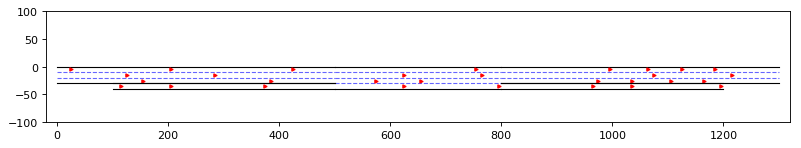

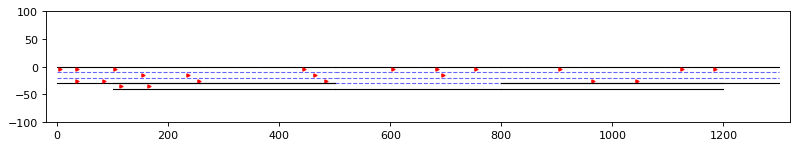

In [7]:
fig = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
draw_simulation_world(ax, world)
plt.show()

In [8]:
car_artists

{140275712596360: <matplotlib.lines.Line2D at 0x7f947736e320>,
 140275712660808: <matplotlib.lines.Line2D at 0x7f9477379860>,
 140276185732424: <matplotlib.lines.Line2D at 0x7f947737fdd8>,
 140276185733832: <matplotlib.lines.Line2D at 0x7f9477389b38>,
 140276185733768: <matplotlib.lines.Line2D at 0x7f9477310898>}